In [1]:
#In this code I'm going to see if we can train a NN from one game and have it predict positions from the next game
#Importing the libraries
from data_loader import FootballDataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
import pickle
import os
import matplotlib.pyplot as plt
from ML_Functions_LoadArrays import *
import numpy as np
import shap
from tensorflow.keras.layers import Masking
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Masking, GRU, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import contextlib
import sys
import os


2025-06-04 11:31:20.960521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 11:31:20.960961: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 11:31:20.963130: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 11:31:20.968721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749029480.979163   57547 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749029480.98

In [2]:
def get_xy_from_XG(XGPos1, XGPos2, team):
    if team == 'AAB':
        x = np.array(XGPos1, dtype=float) / 100 * 105 - 52.5  
        y = np.array(XGPos2, dtype=float) / 100 * 70 - 35
    elif team in ['AGF', 'BIF', 'FCK', 'FCN',  'SIF', 'SJE', 'VFF']:
        x = np.array(XGPos1, dtype=float) / 100 * 105 - 52.5  
        y = np.array(XGPos2, dtype=float) / 100 * 68 - 34
    elif team == 'FCM':
        x = np.array(XGPos1, dtype=float) / 100 * 104 - 52  
        y = np.array(XGPos2, dtype=float) / 100 * 65 - 32.5
    elif team in ['LYN', 'RFC']:
        x = np.array(XGPos1, dtype=float) / 100 * 102 - 51  
        y = np.array(XGPos2, dtype=float) / 100 * 65 - 32.5
    elif team == 'VB':
        x = np.array(XGPos1, dtype=float) / 100 * 108 - 54
        y = np.array(XGPos2, dtype=float) / 100 * 68 - 34
    return x, y

def get_shot_time(times_x, t, Us, Ball, XGNumbers, XGPos1, XGPos2, i, verbose=False):
    passed = False
    idxs = np.where(np.isclose(times_x, t, atol=0.03)) #I believe when XGDat says 50 seconds, it means the shot took place between 49-50 seconds, research shows this is usually true, but sometimes the time in XGData is 3 seconds off...
    if len(idxs[0]) == 0:
        if verbose:
            print(f"Warning: No close time found for {t} in times_x.")
        return 0, passed
    
    idxes = idxs[0][0]  # Get the first index where the time is close
    frames = np.arange(max(0 , idxes-40), min(len(Us), idxes+15)) #So we take the whole second, and also half a second before and after, so we take from 48.5-50.5
    for idx in frames:
        if Ball[idx][5] == 0:
             frames = np.delete(frames, np.where(frames == idx)) #take only the idx in which the ball is being played

    if len(frames) == 0: 
        if verbose:
            print(f"Ball not being played.")
        return 0, passed
    
    else:
        shooter = int(XGNumbers[i])
        shooter_x = float(XGPos1[i])
        shooter_y = float(XGPos2[i])
        #print(shooter, shooter_x, shooter_y, t/60)
        shooter_pos_in_data = next((j for j, player_data in enumerate(Us[frames[0]]) if int(player_data[4]) == shooter), None)

        if shooter_pos_in_data is None:
            if verbose:
                print(f"Warning: player {shooter} not found in Us[{frames[0]}]")
            return 0, passed

        distances = np.array([np.sqrt((Us[idx][shooter_pos_in_data][0] - Ball[idx][0])**2 + (Us[idx][shooter_pos_in_data][1] - Ball[idx][1])**2) for idx in frames])
        mask = ((np.abs(np.array([Us[idx][shooter_pos_in_data][0] for idx in frames]) - shooter_x) <= 1.5) &
                (np.abs(np.array([Us[idx][shooter_pos_in_data][1] for idx in frames]) - shooter_y) <= 1.5))
        distances = distances[mask]
        frames = frames[mask]

        if len(distances) == 0:
            if verbose:
                print(f"Warning: player {shooter} not found in Us[{frames[0]}] within 1.5m of where the player is supposed to be.")
            return 0, passed
        
        else : 
            if min(distances) > 2:
                if verbose:
                    print("Ball - Shooter distance > 2")
                return 0, passed
            passed = True
            if verbose:
                print(f"Shot time found at frame {frames[np.argmin(distances)]} with distance {min(distances)}")
           
            return frames[np.argmin(distances)], passed
 
def get_sequence_by_number(Team, verbose=False):
    broken_NamesSC = ['Game_SJE_BIF_Score_2_2_Day_2024-11-24Z.pkl', 'Game_SJE_VFF_Score_2_2_Day_2024-09-01Z.pkl', 'Game_SJE_FCN_Score_1_4_Day_2024-10-06Z.pkl']
    NamesXG, NamesSC = SortGames('pippo', Team)
    columns = ['XG', 'Time', 'Half','ball_x', 'ball_y', 'ball_z', 'ball_speed']
    for i in range(1, 30):
        columns += [f'us_{i}_x', f'us_{i}_y', f'us_{i}_speed']
        columns += [f'them_{i}_x', f'them_{i}_y', f'them_{i}_speed']
    

    rows = []
    for igame in range(30):
        if NamesSC[igame] not in broken_NamesSC:
            Time, Ball, Us, Them = SecLoad(Team, NamesSC, igame)

            XGNumbers, XGTeam, XGValue, XGHalf, XGMin, XGSec, XGTimes, XGPos1, XGPos2 = (
                MacihneLearning_OptaLoad(Team, NamesXG, igame)
            )

            XG_x, XG_y = get_xy_from_XG(XGPos1, XGPos2, NamesSC[igame].split('_')[1])  # Assuming the pitch size is based on the team name in the file

            times_x = np.array([t[0] for t in Time])
            XGs = []
            for i, t in enumerate(XGTimes):
                if XGValue[i] > 0:
                    xg_moment = XGValue[i]
                    
                    if XGTeam[i] == Team:
                        idx, passed = get_shot_time(times_x, t, Us, Ball, XGNumbers, XG_x, XG_y, i, verbose=verbose)
                    else: 
                        xg_moment = -xg_moment  # If the team is not the one we are looking for, we negate the XG value
                        idx, passed = get_shot_time(times_x, t, Them, Ball, XGNumbers, -1*XG_x, -1*XG_y, i, verbose=verbose)

                    if passed:
                        numbers_us = [int(player[4]) for player in Us[idx]]
                        numbers_them = [int(player[4]) for player in Them[idx]]
                        us_ordered = sorted(range(len(numbers_us)), key=lambda k: numbers_us[k])
                        them_ordered = sorted(range(len(numbers_them)), key=lambda k: numbers_them[k])
                        Us[idx] = [Us[idx][j] for j in us_ordered]
                        Them[idx] = [Them[idx][j] for j in them_ordered]
                        frames_definig_play = np.arange(max(0 , idx-125*2), idx) 
                        Ball_values = np.array([Ball[frame][5] for frame in frames_definig_play])
                        find_stop = np.where(Ball_values == 0)[0][-1] if np.any(Ball_values == 0) else None
                        if find_stop is not None:
                            frames_definig_play = frames_definig_play[find_stop:]
                        for time in frames_definig_play : 
                            row = {}
                            row['XG'] = xg_moment
                            row['Time'] = Time[time][0]
                            row['Half'] = XGHalf[i]
                            row['ball_x'] =  Ball[time][0] * np.sign(Ball[time][0]) * np.sign(xg_moment)
                            row['ball_y'] =  Ball[time][1]
                            row['ball_z'] =  Ball[time][2]
                            row['ball_speed'] =  Ball[time][3]
                            for j in range(len(Us[time])):
                                row[f'us_{numbers_us[j]}_x'] = Us[time][j][0]*np.sign(Ball[time][0]) * np.sign(xg_moment)
                                row[f'us_{numbers_us[j]}_y'] = Us[time][j][1]
                                row[f'us_{numbers_us[j]}_speed'] = Us[time][j][3]
                            for j in range(len(Them[time])):
                                row[f'them_{j+1}_x'] = Them[time][j][0]*np.sign(Ball[time][0]) * np.sign(xg_moment)
                                row[f'them_{j+1}_y'] = Them[time][j][1]
                                row[f'them_{j+1}_speed'] = Them[time][j][3]
                     
                            rows.append(row)
                        XGs.append(XGValue[i])
                            

    total_XG_data = pd.DataFrame(rows, columns=columns)
    return total_XG_data, XGs

#dist_l = []
#tXG_all, Xgs = get_sequence_by_number('AGF', verbose=False) #1 team takes +- 1 min,  
#tXG_all = tXG_all.dropna(axis=1, how='all')
#print("Team AAB done")
#
#for team in ['AGF' , 'AAB' , 'BIF', 'FCK', 'FCM', 'FCN', 'RFC', 'SIF', 'SJE', 'VB', 'VFF', 'LYN']: # missing 
#    tXG, d_l = get_sequence_by_number(team) 
#    print(f"Team {team} done")
#    tXG.to_csv(f'XGData_sequencies_{team}.csv', index=False)

In [3]:
tXG_all = pd.read_csv('XGData_sequencies_AAB.csv')
print(tXG_all.shape)

(70413, 181)


In [4]:
cols_to_drop = [col for col in tXG_all.columns if ('speed' in col or 'Time' in col  or 'Half' in col)]
#cols_to_drop += [col for col in tXG_all.columns if '11'  in col]
tXG_all = tXG_all.drop(columns=cols_to_drop)
shot = 0 
XG_n = [0]
i = 0
while i < len(tXG_all):
    XG_n.append(shot)
    while i + 1 < len(tXG_all) and abs(tXG_all['XG'][i] - tXG_all['XG'][i + 1]) < 0.0001:
        i += 1
        XG_n.append(shot)
    shot += 1
    i += 1

# Rimuovi il primo elemento extra se necessario (perché XG_n parte da [0])
XG_n = XG_n[:len(tXG_all)]
tXG_all['XG_n'] = XG_n


In [5]:
#print("Shape del dataset:", tXG_all.shape)
#print("\nPrime 5 righe del dataset:")
#display(tXG_all.head())
#
#print("\nStatistiche descrittive sulle colonne numeriche:")
#display(tXG_all.describe())
#
#print("\nPercentuale di valori mancanti per colonna:")
#missing_percent = tXG_all.isnull().mean() * 100
#print(missing_percent.sort_values(ascending=False))
#
#print("\nNumero di valori unici per colonna:")
#unique_counts = tXG_all.nunique()
#print(unique_counts.sort_values(ascending=False))

min_presence = 0.20
threshold = int(min_presence * len(tXG_all))
cols_to_keep = [col for col in tXG_all.columns if tXG_all[col].count() >= threshold]
tXG_all = tXG_all[cols_to_keep]
removed_cols = [col for col in tXG_all.columns if col not in cols_to_keep]


#print("\nPercentuale di valori mancanti per colonna:")
#missing_percent = tXG_all.isnull().mean() * 100
#print(missing_percent.sort_values(ascending=False))

In [6]:
train_positions = tXG_all.drop(tXG_all.columns[[0]], axis=1)

grpous = tXG_all.groupby('XG_n')
xg_groups = {group['XG'].iloc[0]: {'group': group, 'n': name} for name, group in grpous}
train_X = []
train_y = []
appo = []

for xg_val, group_info in xg_groups.items():
    group_df = group_info['group']
    appo = []
    for i in range(group_df.shape[0] - 1, 100 , -5):
        appo.append(group_df.drop(['XG' , 'XG_n'], axis=1).iloc[i].values)
    appo = np.array(appo)
    appo = np.flip(appo, axis=0)  # Flip the sequence per avere ordine temporale corretto
    train_X.append(appo)
    train_y.append(xg_val)

train_X = np.array(train_X, dtype=object)
train_y = np.array(train_y, dtype=float)

print("Shape of train_X:", train_X.shape)
print("Shape of train_y:", train_y.shape)

Shape of train_X: (314,)
Shape of train_y: (314,)


In [7]:
maxlen = max([seq.shape[0] for seq in train_X])

train_X_padded = pad_sequences(train_X, maxlen=maxlen, dtype='float32', padding='post')
train_y = np.nan_to_num(train_y, nan=0.0, posinf=0.0, neginf=0.0)

num_samples, timesteps, num_features = train_X_padded.shape
scaler = StandardScaler()
train_X_padded = scaler.fit_transform(train_X_padded.reshape(-1, num_features)).reshape(num_samples, timesteps, num_features)
train_X_padded = np.nan_to_num(train_X_padded, nan=-100.0, posinf=0.0, neginf=0.0)

print("Shape of train_X_padded:", train_X_padded.shape)
print("Shape of train_y:", train_y.shape)

Shape of train_X_padded: (314, 30, 63)
Shape of train_y: (314,)


In [8]:
X_train_padded_negative = train_X_padded[train_y <= 0]
X_train_padded_positive = train_X_padded[train_y > 0]
train_y_negative = train_y[train_y <= 0]
train_y_positive = train_y[train_y > 0]

# Splitting the data into training and testing sets
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_train_padded_positive, train_y_positive, test_size=0.15, random_state=42)
X_train_negative, X_test_negative, y_train_negative, y_test_negative = train_test_split(X_train_padded_negative, train_y_negative, test_size=0.15, random_state=42)



Data clean from here

2025-06-04 11:31:23.825862: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-06-04 11:31:25.579381: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Epoch 50: Loss = 0.09355810284614563, Val Loss = 0.151085764169693
Epoch 100: Loss = 0.08620854467153549, Val Loss = 0.15060195326805115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0167 - mae: 0.0957
Test Loss (positive): 0.01668338105082512, Test MAE (positive): 0.09569600224494934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


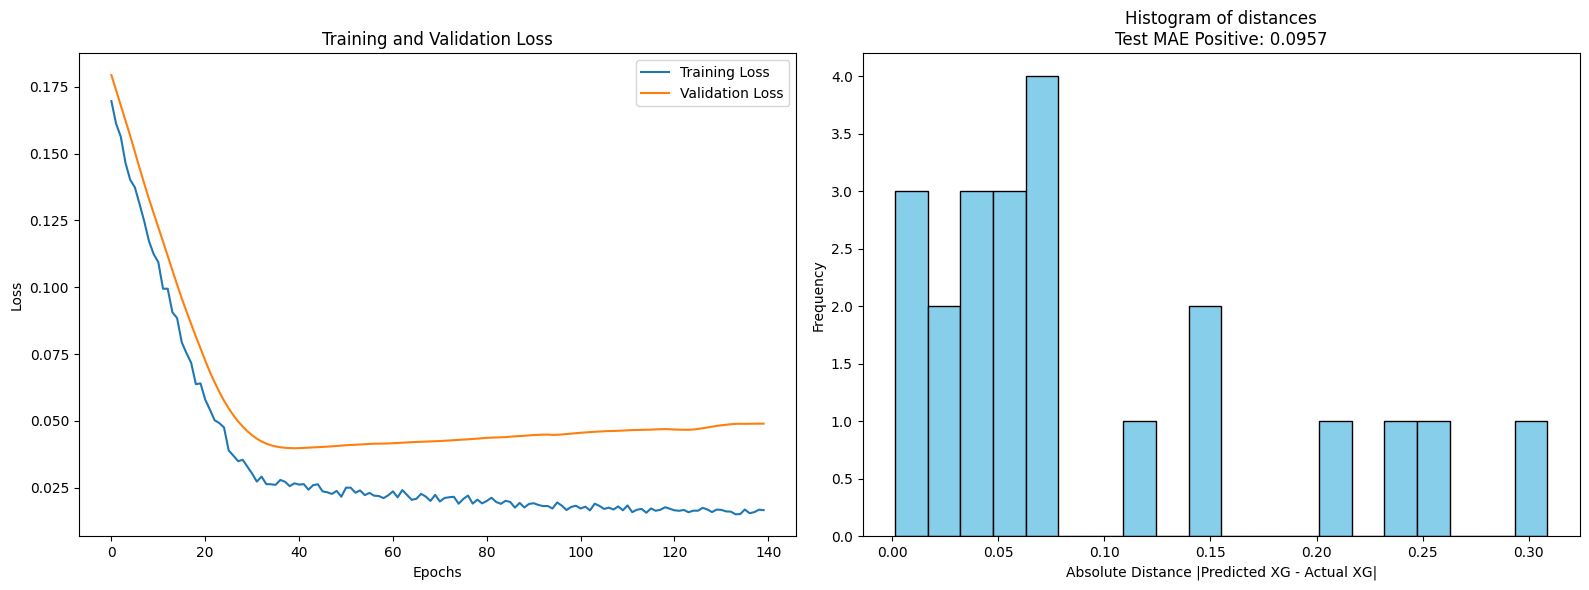

In [9]:
inputs = Input(shape=(maxlen, num_features))
x = Masking(mask_value=-100.0)(inputs)
x = GRU(64, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='sigmoid')(x)
outputs = Dense(1, activation='linear')(x)

model_positive = Model(inputs, outputs)
model_positive.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

model_positive.fit(
    X_train_positive, y_train_positive,
    epochs=500,
    batch_size=64,
    validation_split=0.2,
    verbose=0, 
    shuffle=True,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
        keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: 
                print(f"Epoch {epoch + 1}: Loss = {logs['mae']}, Val Loss = {logs['val_mae']}")
                if (epoch + 1) % 50 == 0 else None
        )
    ]
)

# Valuta il modello positive sui dati di test positivi
loss, mae = model_positive.evaluate(X_test_positive, y_test_positive)
print(f"Test Loss (positive): {loss}, Test MAE (positive): {mae}")

# Previsioni sui dati di test positivi
predictions = model_positive.predict(X_test_positive)
distances = np.abs(predictions.flatten() - y_test_positive)

# Plot training history e istogramma delle distanze
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Training history
history = model_positive.history.history
axs[0].plot(history['loss'], label='Training Loss')
axs[0].plot(history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Histogram of distances
axs[1].hist(distances, bins=20, color='skyblue', edgecolor='black')
axs[1].set_xlabel('Absolute Distance |Predicted XG - Actual XG|')
axs[1].set_ylabel('Frequency')
axs[1].set_title(f'Histogram of distances\nTest MAE Positive: {mae:.4f}')

plt.tight_layout()
plt.show()

In [10]:
idx = np.random.choice(X_test_positive.shape[0], 20)
X_sample_seq = X_test_positive[idx]
X_sample_seq_flat = X_sample_seq.reshape(X_sample_seq.shape[0], -1)

def model_predict_flat(x):
    x_seq = x.reshape((x.shape[0], X_sample_seq.shape[1], X_sample_seq.shape[2]))
    return model_positive.predict(x_seq)
with open(os.devnull, "w") as fnull, \
    contextlib.redirect_stdout(fnull), \
    contextlib.redirect_stderr(fnull):
    explainer = shap.KernelExplainer(model_predict_flat, X_sample_seq_flat)
    shap_values = explainer.shap_values(X_sample_seq_flat, nsamples=50, silent=True, progress_bar=False)

In [11]:
timesteps = X_sample_seq.shape[1]
num_features = X_sample_seq.shape[2]
base_feature_names = train_positions.drop(['XG_n'], axis=1).columns.tolist()

mean_importance = np.mean(shap_values, axis=0)  # shape: (timesteps * num_features,)
mean_importance = mean_importance.reshape(timesteps, num_features)

mean_importance_per_feature = mean_importance.mean(axis=0)  # shape: (num_features,)

importances_df = pd.DataFrame({
    'feature': base_feature_names,
    'mean_shap': mean_importance_per_feature
}).sort_values('mean_shap', ascending=False)

/tmp/ipykernel_57547/3096004038.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


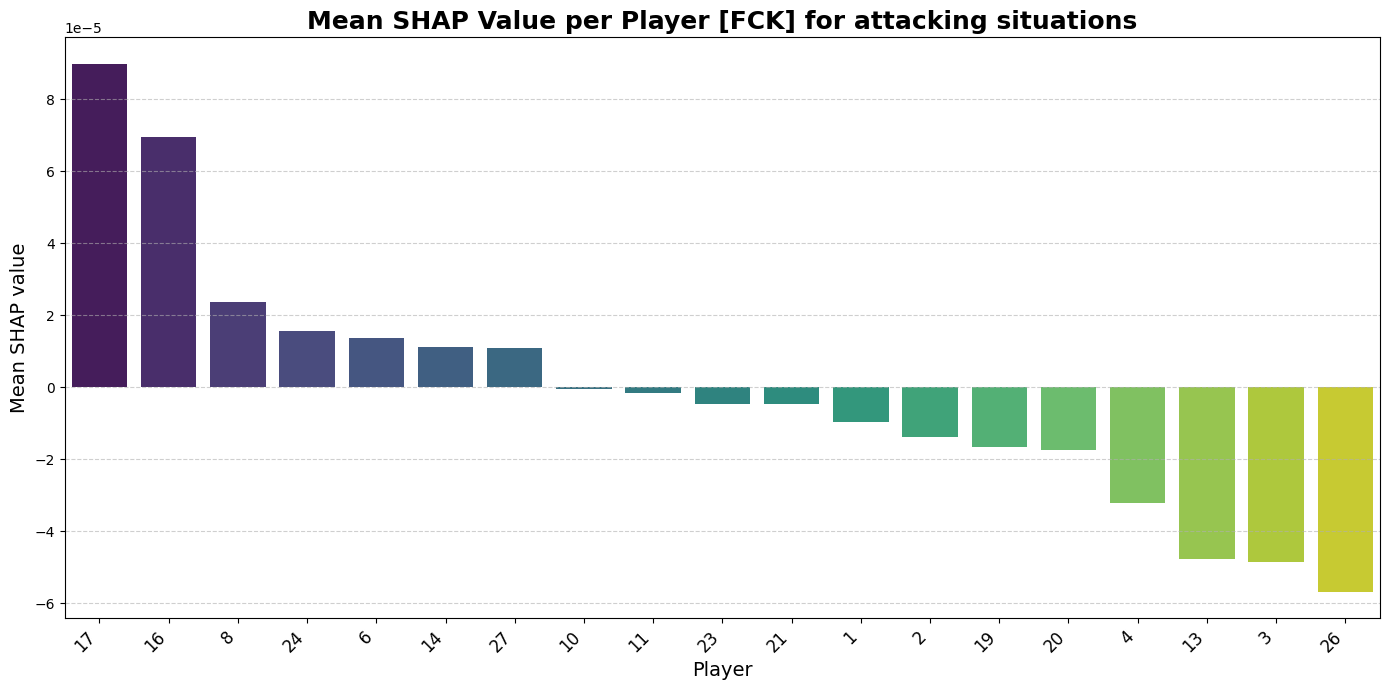

{'17': 8.989016047293019e-05, '16': 6.940807164555457e-05, '8': 2.3748198263182927e-05, '24': 1.564096413724119e-05, '6': 1.3545790143271236e-05, '14': 1.1099095183237108e-05, '27': 1.0932988319182586e-05, '10': -6.064970473162593e-07, '11': -1.634446002512785e-06, '23': -4.556750076257373e-06, '21': -4.6517715462634425e-06, '1': -9.61307901832982e-06, '2': -1.3745476113000158e-05, '19': -1.661013112803555e-05, '20': -1.7459573013992595e-05, '4': -3.227407693420278e-05, '13': -4.780912418530326e-05, '3': -4.851185152909101e-05, '26': -5.679503188635481e-05}


In [12]:
players = [col.split('_')[1] for col in importances_df.feature if 'us_' in col]


def shape_mean(number, df ) : 
    str_to_find = '_' + str(number) + '_'
    raw = [col for col in df.feature if str_to_find in col]
    return df[df.feature.isin(raw)].mean_shap.mean()

# Calculate the mean SHAP value for each player
mean_shap_values = {}
for i in (players):
    mean_shap_values[f'{i}'] = shape_mean(i, importances_df)


mean_shap_values = dict(sorted(mean_shap_values.items(), key=lambda item: item[1], reverse=True))


plt.figure(figsize=(14, 7))
sns.barplot(
    x=list(mean_shap_values.keys()),
    y=list(mean_shap_values.values()),
    palette="viridis"
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Mean SHAP Value per Player [FCK] for attacking situations', fontsize=18, fontweight='bold')
plt.ylabel('Mean SHAP value', fontsize=14)
plt.xlabel('Player', fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
print(mean_shap_values)

In [13]:
print("Trining neative size :", X_train_negative.shape)
print("Testing neative size :", X_test_negative.shape)

Trining neative size : (145, 30, 63)
Testing neative size : (26, 30, 63)


Epoch 50: Loss = 0.08911469578742981, Val Loss = 0.12902753055095673
Epoch 100: Loss = 0.08261562138795853, Val Loss = 0.12338494509458542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0234 - mae: 0.0973
Test Loss (negative): 0.023369252681732178, Test MAE (negative): 0.09729526937007904
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


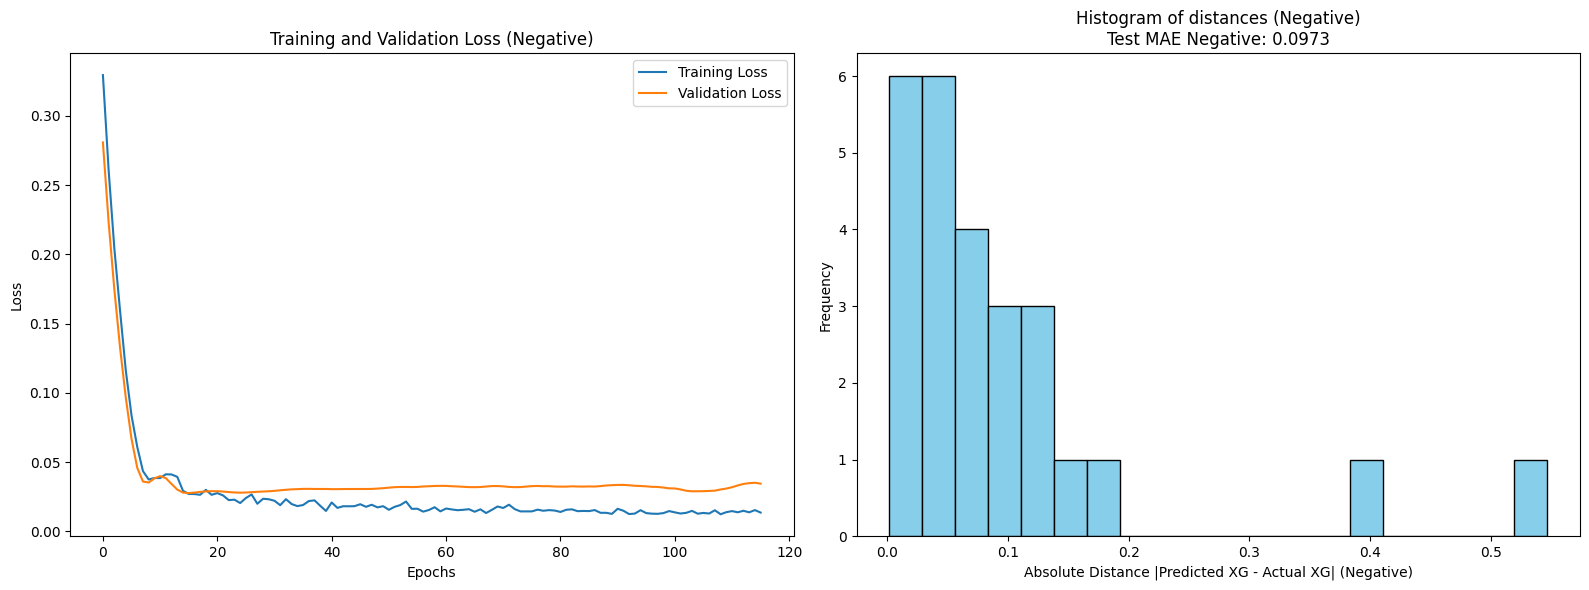

In [14]:
outputs_negative = Dense(1, activation=None)(x)  # output lineare, non sigmoid
inputs_negative = Input(shape=(maxlen, num_features))

nputs_negative = Input(shape=(maxlen, num_features))
x_neg = Masking(mask_value=-100.0)(inputs_negative)
x_neg = GRU(64, return_sequences=True)(x_neg)
x_neg = Dropout(0.1)(x_neg)
x_neg = LSTM(64, return_sequences=False)(x_neg)
x_neg = Dropout(0.1)(x_neg)
x_neg = Dense(64, activation='relu')(x_neg)
x_neg = Dropout(0.1)(x_neg)
x_neg = Dense(64, activation='relu')(x_neg)
x_neg = Dense(16, activation='sigmoid')(x_neg)
outputs_negative = Dense(1, activation=None)(x_neg)  # output lineare

model_negative = Model(inputs_negative, outputs_negative)
model_negative.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
model_negative.fit(
    X_train_negative, y_train_negative,
    epochs=500,
    batch_size=64,
    validation_split=0.2,
    verbose=0, 
    shuffle=True,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
        keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: 
                print(f"Epoch {epoch + 1}: Loss = {logs['mae']}, Val Loss = {logs['val_mae']}")
                if (epoch + 1) % 50 == 0 else None
        )
    ]
)

# Valuta il modello negativo sui dati di test negativi
loss, mae = model_negative.evaluate(X_test_negative, y_test_negative)
print(f"Test Loss (negative): {loss}, Test MAE (negative): {mae}")
# Previsioni sui dati di test negativi
predictions_negative = model_negative.predict(X_test_negative)
distances_negative = np.abs(predictions_negative.flatten() - y_test_negative)
# Plot training history e istogramma delle distanze
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# Training history
history_negative = model_negative.history.history
axs[0].plot(history_negative['loss'], label='Training Loss')
axs[0].plot(history_negative['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss (Negative)')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Histogram of distances
axs[1].hist(distances_negative, bins=20, color='skyblue', edgecolor='black')
axs[1].set_xlabel('Absolute Distance |Predicted XG - Actual XG| (Negative)')
axs[1].set_ylabel('Frequency')
axs[1].set_title(f'Histogram of distances (Negative)\nTest MAE Negative: {mae:.4f}')
plt.tight_layout()
plt.show()

In [15]:
# Calcola le distanze assolute tra predizione e valore reale
distances_negative = np.abs(predictions_negative.flatten() - y_test_negative)

# Trova l'indice della distanza massima
idx_max = np.argmax(distances_negative)

# Stampa la predizione, il valore reale e la distanza massima
print("Predizione:", predictions_negative[idx_max][0])
print("Valore reale:", y_test_negative[idx_max])
print("Distanza:", distances_negative[idx_max])

Predizione: -0.1675158
Valore reale: -0.713851809501648
Distanza: 0.5463360100984573


In [16]:
print(np.std(X_test_negative))

43.31347


In [17]:
idx = np.random.choice(X_test_negative.shape[0])
X_sample_seq_negative = X_test_negative
X_sample_seq_flat_negative = X_sample_seq_negative.reshape(X_sample_seq_negative.shape[0], -1)
def model_predict_flat_negative(x):
    x_seq = x.reshape((x.shape[0], X_sample_seq_negative.shape[1], X_sample_seq_negative.shape[2]))
    return model_negative.predict(x_seq)

with open(os.devnull, "w") as fnull, \
     contextlib.redirect_stdout(fnull), \
     contextlib.redirect_stderr(fnull):
    explainer_negative = shap.KernelExplainer(model_predict_flat_negative, X_sample_seq_flat_negative, silent=True, progress_bar=False)
    shap_values_negative = explainer_negative.shap_values(X_sample_seq_flat_negative, nsamples=50, silent=True, progress_bar=False)
mean_importance_negative = np.mean(shap_values_negative, axis=0)  
mean_importance_negative = mean_importance_negative.reshape(timesteps, num_features)
mean_importance_per_feature_negative = mean_importance_negative.mean(axis=0)  
importances_df_negative = pd.DataFrame({
    'feature': base_feature_names,
    'mean_shap': mean_importance_per_feature_negative.astype(float) 
}).sort_values('mean_shap', ascending=False)
print(importances_df_negative)

      feature  mean_shap
51    us_20_x   0.000198
5    them_1_x   0.000117
16     us_4_y   0.000106
19   them_5_x   0.000042
48    us_17_y   0.000038
..        ...        ...
47    us_17_x  -0.000052
43    us_14_x  -0.000058
35  them_10_x  -0.000064
21     us_6_x  -0.000071
14   them_3_y  -0.000195

[63 rows x 2 columns]


['20', '4', '17', '21', '26', '27', '8', '16', '23', '13', '24', '21', '2', '19', '24', '13', '8', '19', '16', '20', '10', '6', '14', '1', '11', '11', '27', '4', '2', '1', '3', '26', '23', '3', '10', '17', '14', '6']
{'20': 0.00010010273085961782, '1': 2.8116946891465146e-05, '4': 2.2266261425476935e-05, '21': 2.0093354420556823e-05, '16': 1.3213249280398626e-05, '13': 1.0476722735248889e-05, '24': 8.960509452612551e-06, '2': 7.93208233006064e-06, '27': 6.865527074736135e-06, '19': 5.771500166103822e-06, '8': 5.041911217142291e-06, '26': 1.7918497180323665e-06, '23': -4.287373951471551e-06, '17': -7.347735454003605e-06, '11': -1.0154833462372104e-05, '6': -2.0761959863661593e-05, '14': -2.9841271719860016e-05, '10': -3.3056712790356845e-05, '3': -6.154943992155353e-05}


/tmp/ipykernel_57547/784447904.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


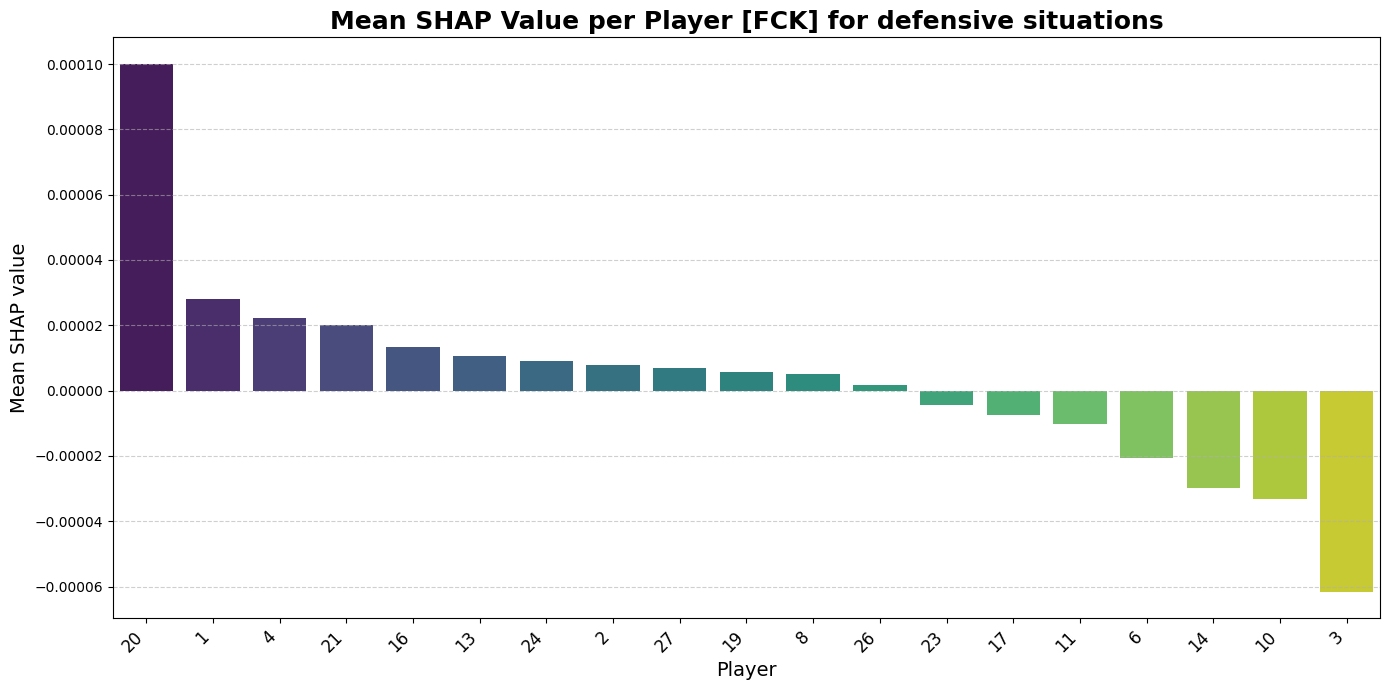

In [18]:
players_negative = [col.split('_')[1] for col in importances_df_negative.feature if 'us_' in col]
print(players_negative)

def shape_mean_negative(number, df ) : 
    str_to_find = '_' + str(number) + '_'
    raw = [col for col in df.feature if str_to_find in col]
    return df[df.feature.isin(raw)].mean_shap.mean()
# Calculate the mean SHAP value for each player
mean_shap_values_negative = {}
for i in (players_negative):
    mean_shap_values_negative[f'{i}'] = shape_mean_negative(i, importances_df_negative)
mean_shap_values_negative = dict(sorted(mean_shap_values_negative.items(), key=lambda item: item[1], reverse=True))
print(mean_shap_values_negative)
plt.figure(figsize=(14, 7))
sns.barplot(
    x=list(mean_shap_values_negative.keys()),
    y=list(mean_shap_values_negative.values()),
    palette="viridis"
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Mean SHAP Value per Player [FCK] for defensive situations', fontsize=18, fontweight='bold')
plt.ylabel('Mean SHAP value', fontsize=14)
plt.xlabel('Player', fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


/tmp/ipykernel_57547/574533337.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Mean SHAP value')

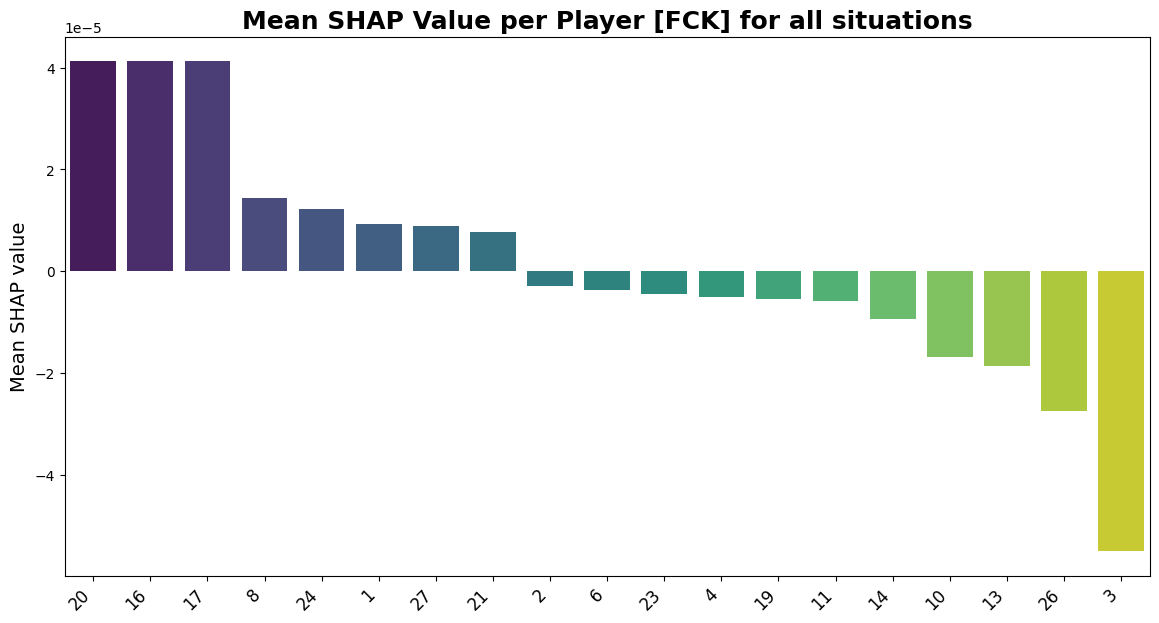

In [19]:
average_shap_total = {}
for player in mean_shap_values.keys():
    if player in mean_shap_values_negative:
        average_shap_total[player] = (mean_shap_values[player] + mean_shap_values_negative[player]) / 2
    else:
        average_shap_total[player] = mean_shap_values[player]
average_shap_total = dict(sorted(average_shap_total.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(14, 7))
sns.barplot(
    x=list(average_shap_total.keys()),
    y=list(average_shap_total.values()),
    palette="viridis"
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Mean SHAP Value per Player [FCK] for all situations', fontsize=18, fontweight='bold')
plt.ylabel('Mean SHAP value', fontsize=14)

In [20]:
pd.DataFrame(list(average_shap_total.items()), columns=['player', 'mean_shap']).to_csv('AAB_shap_total.csv', index=False)